In [258]:
import pyspark
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn
import pandas as pd
import datetime

%matplotlib inline

plt.style.use('default') 

sbn.set(style="whitegrid") 

# **Apertura de archivos a usar durante la resolucion del trabajo practico.**

In [96]:
postulaciones_educacion = pd.read_csv('fiuba_1_postulantes_educacion.csv')
postulaciones_genero_edad = pd.read_csv('fiuba_2_postulantes_genero_y_edad.csv')
vistas = pd.read_csv('fiuba_3_vistas.csv')
postulaciones = pd.read_csv('fiuba_4_postulaciones.csv')
avisos_online = pd.read_csv('fiuba_5_avisos_online.csv')
avisos_detalle = pd.read_csv('fiuba_6_avisos_detalle.csv')

# Preparando los datos para el analisis

## Archivo 'postulaciones'

In [97]:
postulaciones.isnull().any()

idaviso             False
idpostulante        False
fechapostulacion    False
dtype: bool

In [98]:
#Creo columnas para poder utilizar la fecha y el horario mas comodamente, en el archivo de Postulaciones
postulaciones['date'] = pd.to_datetime(postulaciones['fechapostulacion']).dt.date
postulaciones['time'] = pd.to_datetime(postulaciones['fechapostulacion']).dt.time
postulaciones.head()

,idaviso,idpostulante,fechapostulacion,date,time
0,1112257047,NM5M,2018-01-15 16:22:34,2018-01-15,16:22:34
1,1111920714,NM5M,2018-02-06 09:04:50,2018-02-06,09:04:50
2,1112346945,NM5M,2018-02-22 09:04:47,2018-02-22,09:04:47
3,1112345547,NM5M,2018-02-22 09:04:59,2018-02-22,09:04:59
4,1112237522,5awk,2018-01-25 18:55:03,2018-01-25,18:55:03


In [143]:
print(postulaciones.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3401623 entries, 0 to 3401622
Data columns (total 5 columns):
idaviso             int64
idpostulante        object
fechapostulacion    object
date                object
time                object
dtypes: int64(1), object(4)
memory usage: 129.8+ MB
None


In [99]:
#Veo si hay filas duplicadas con los mismos valores en todas las columnas
postulaciones.duplicated().any()

False

## Archivo 'avisos_detalle'

In [100]:
avisos_detalle.isnull().any()

idaviso                 False
idpais                  False
titulo                  False
descripcion             False
nombre_zona             False
ciudad                   True
mapacalle                True
tipo_de_trabajo         False
nivel_laboral           False
nombre_area             False
denominacion_empresa     True
dtype: bool

In [101]:
#ESTE DF TIENE DATOS NULOS EN LAS COLUMNAS DE 'CIUDAD', 'MAPACALLE' Y 'DENOMINACION_EMPRESA'. 
#Decidimos eliminarlas ya que no nos parecieron muy relevantes para el analisis
avisos_detalle.drop(['ciudad','mapacalle','denominacion_empresa','descripcion'],1,inplace=True)
#avisos_detalle.drop('descripcion',1,inplace=True)

In [102]:
#Asi quedaria finalmente el archivo 'avisos_detalle' para el analisis
avisos_detalle.head()

,idaviso,idpais,titulo,nombre_zona,tipo_de_trabajo,nivel_laboral,nombre_area
0,8725750,1,VENDEDOR/A PROVINCIA DE SANTA FE,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Comercial
1,17903700,1,Enfermeras,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Salud
2,1000150677,1,Chofer de taxi,Capital Federal,Full-time,Senior / Semi-Senior,Transporte
3,1000610287,1,CHOFER DE CAMIONETA BAHIA BLANCA - PUNTA ALTA,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Transporte
4,1000872556,1,Operarios de Planta - Rubro Electrodomésticos,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Producción


## Archivo 'postulaciones_genero_edad'

In [103]:
postulaciones_genero_edad.isnull().any()

idpostulante       False
fechanacimiento     True
sexo               False
dtype: bool

In [104]:
#Veo si hay filas duplicadas con los mismos valores en todas las columnas
postulaciones_genero_edad.duplicated().any()

False

In [105]:
#Veo si hay usuarios duplicados
postulaciones_genero_edad['idpostulante'].duplicated().any()

False

In [106]:
#Este archivo posee datos nulos en la columna 'fechanacimiento', lo cual traeria dificultades a la hora de querer 
#analizar los datos segun la edad de los postulantes.

#En primer instancia le asignamos el año actual, para poder comenzar con el analisis.
postulaciones_genero_edad = postulaciones_genero_edad.fillna(2018-1-1)

In [107]:
postulaciones_genero_edad.isnull().any()

idpostulante       False
fechanacimiento    False
sexo               False
dtype: bool

## Archivo 'postulaciones_educacion'

In [108]:
postulaciones_educacion.isnull().any()

idpostulante    False
nombre          False
estado          False
dtype: bool

In [109]:
#Veo si hay filas de datos duplicados
postulaciones_educacion.duplicated().any()

False

In [110]:
postulaciones_educacion.duplicated(subset = 'idpostulante').any()

True

Hay ids de postulantes duplicados. Quiere decir que hay personas que poseen difenrestes tipos de educacion, carreras terminadas otras por terminar u abandonadas.

## Archivo 'vistas'

In [111]:
vistas.isnull().any()

idAviso         False
timestamp       False
idpostulante    False
dtype: bool

In [112]:
vistas.duplicated().any()

False

## Arichivo 'avisos_online'

In [113]:
avisos_online.isnull().any()

idaviso    False
dtype: bool

In [114]:
avisos_online.duplicated().any()

False

# Algunos graficos de cada archivo por separado

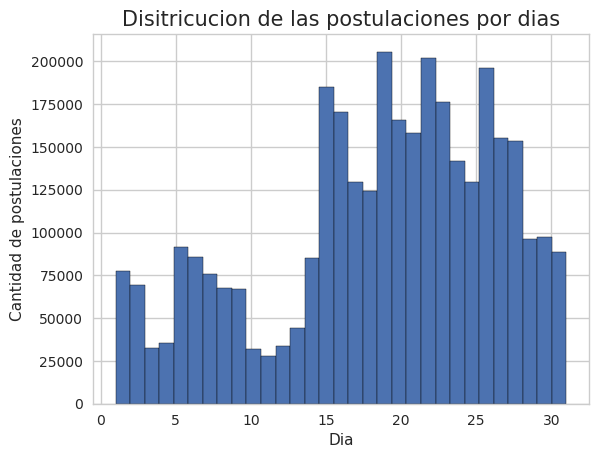

In [253]:
#Dsitricucion de las postulaciones por dia de la semana
g_day = pd.to_datetime(postulaciones['date']).dt.day.hist(bins=31,edgecolor='black');
g_day.set_title('Disitricucion de las postulaciones por dias',fontsize=15)
g_day.set_xlabel('Dia')
g_day.set_ylabel('Cantidad de postulaciones');

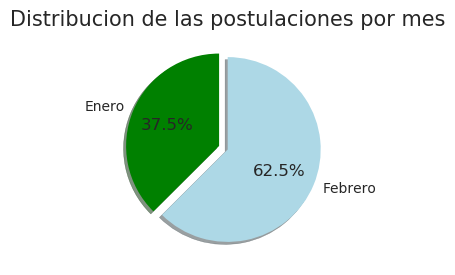

In [451]:
enero = postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 1]
enero = pd.DataFrame(enero)

febrero = postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 2]
febrero = pd.DataFrame(febrero)

sizes = [enero.count(),febrero.count()]
names = ['Enero', 'Febrero']

plt.figure(figsize=(3, 3))
plt.title('Distribucion de las postulaciones por mes', fontsize=15)
plt.pie(sizes, labels=names, autopct='%1.1f%%', startangle=90, colors=['green', 'lightblue'], explode=(0.1, 0),shadow=True)
plt.show()

Ambos graficos son engañosos. El primero muestra que hay mas postulaciones en la segunda mitad de los meses pero eso es porque los datos de Enero son solo de la segunda mitad del mes. De igual manera el sugundo grafico muestra que Enero tiene practicamente la mitad de postulaciones que Febrero. Tambien se debe a lo comentado anteriormente, solo hay datos de la segunda mitad de Enero.

In [117]:
#Total de postulaciones en Enero
enero = postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 1]
pd.DataFrame(enero).count()


date    1276198
dtype: int64

In [118]:
#Fechas diferentes de las cuales se tienen datos en Enero
enero = postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 1]
enero = pd.DataFrame(enero.unique()).sort_values(by=0, ascending=False)
enero[0].count()


17

In [119]:
#Solo hay datos de la segunda mitad de Enero
enero = postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 1]
enero = pd.DataFrame(enero.unique()).sort_values(by=0, ascending=False)
enero

,0
6,2018-01-31
5,2018-01-30
2,2018-01-29
16,2018-01-28
15,2018-01-27
4,2018-01-26
1,2018-01-25
3,2018-01-24
8,2018-01-23
14,2018-01-22


In [120]:
#Total de postulaciones en Febrero
febrero = postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 2]
pd.DataFrame(febrero).count()

date    2125425
dtype: int64

In [121]:
##Fechas diferentes de las cuales se tienen datos en Febrero
febrero = postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 2]
febrero = pd.DataFrame(febrero.unique()).sort_values(by=0, ascending=False)
febrero[0].count()


28

In [122]:
#Febrero tiene los dias completos
febrero = postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 2]
febrero = pd.DataFrame(febrero.unique()).sort_values(by=0, ascending=False)
febrero

,0
6,2018-02-28
10,2018-02-27
13,2018-02-26
26,2018-02-25
25,2018-02-24
15,2018-02-23
1,2018-02-22
9,2018-02-21
20,2018-02-20
5,2018-02-19


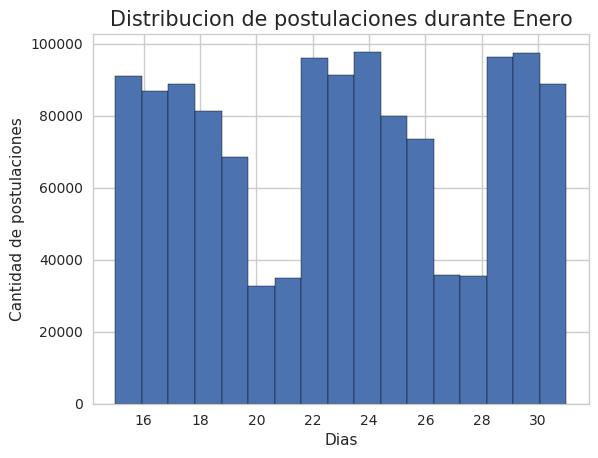

In [123]:
g_month_enero = pd.to_datetime(postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 1]).dt.day.hist(bins=17,edgecolor='black');
g_month_enero.set_title('Distribucion de postulaciones durante Enero',fontsize=15)
g_month_enero.set_xlabel('Dias')
g_month_enero.set_ylabel('Cantidad de postulaciones');

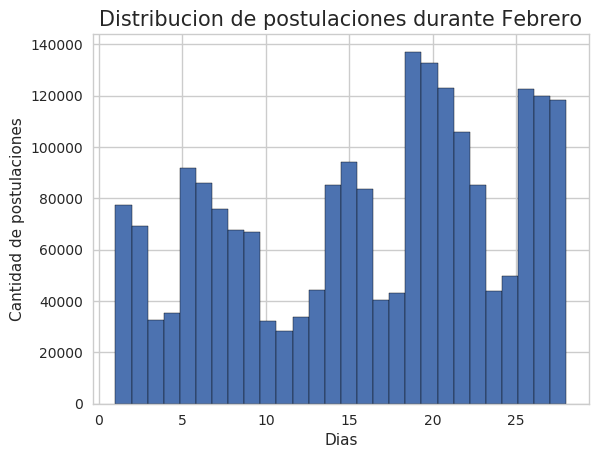

In [124]:
g_month_febrero = pd.to_datetime(postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 2]).dt.day.hist(bins=28,edgecolor='black');
g_month_febrero.set_title('Distribucion de postulaciones durante Febrero',fontsize=15)
g_month_febrero.set_xlabel('Dias')
g_month_febrero.set_ylabel('Cantidad de postulaciones');

**ANALIZAR ESOS BAJONES EN LOS GRAFICOS DE ENERO Y FEBRERO, POR QUE SE DAN? QUE PASA? QUE DIAS CAEN? SON FINES DE SEMANA?**

In [125]:
#este df contiene solo los dias entre el 15 y 28 de cada mes
enero_febrero_igual_dias = pd.DataFrame(columns = ['date'])
enero_febrero_igual_dias['date'] = postulaciones['date'][(pd.to_datetime(postulaciones['date']).dt.day > 14) & (pd.to_datetime(postulaciones['date']).dt.day < 29)]

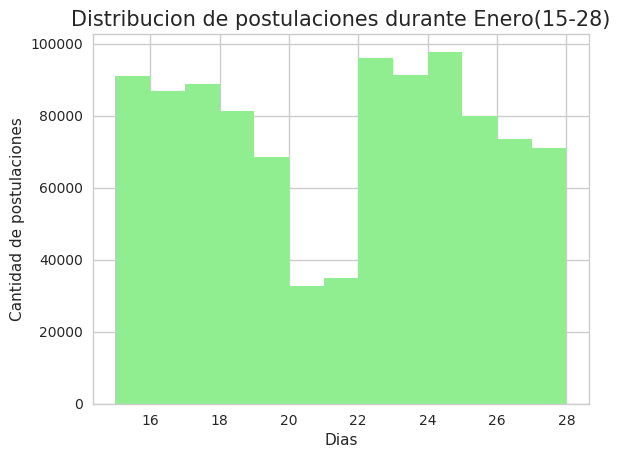

In [126]:
hist_enero_edit = pd.to_datetime(enero_febrero_igual_dias['date'][pd.to_datetime(enero_febrero_igual_dias['date']).dt.month == 1]).dt.day.hist(bins=13,color= 'lightgreen');
hist_enero_edit.set_title('Distribucion de postulaciones durante Enero(15-28)',fontsize=15)
hist_enero_edit.set_xlabel('Dias')
hist_enero_edit.set_ylabel('Cantidad de postulaciones');

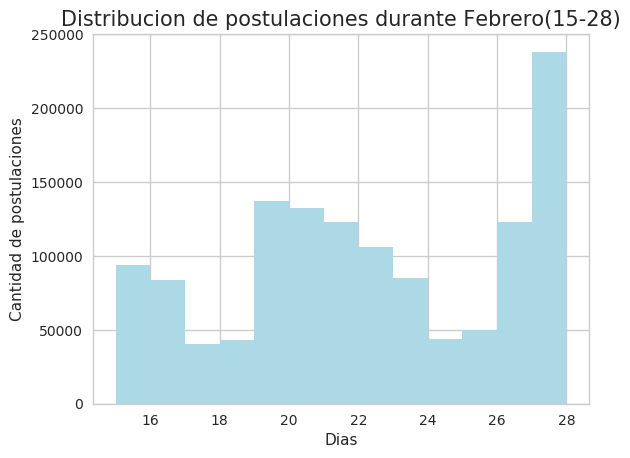

In [127]:
hist_Febrero_edit = pd.to_datetime(enero_febrero_igual_dias['date'][pd.to_datetime(enero_febrero_igual_dias['date']).dt.month == 2]).dt.day.hist(bins=13,color='lightblue');
hist_Febrero_edit.set_title('Distribucion de postulaciones durante Febrero(15-28)',fontsize=15)
hist_Febrero_edit.set_xlabel('Dias')
hist_Febrero_edit.set_ylabel('Cantidad de postulaciones');

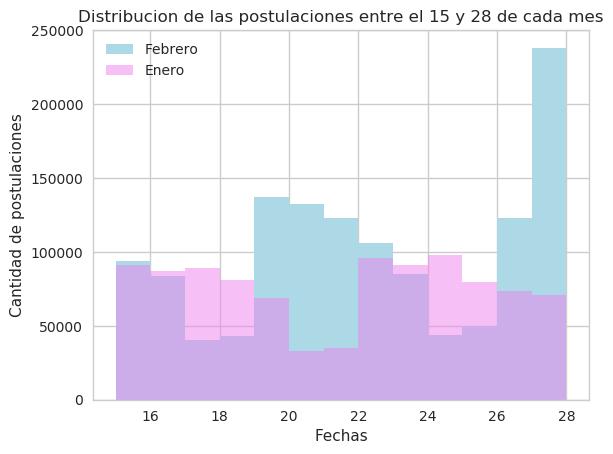

In [128]:
plt.hist(pd.to_datetime(enero_febrero_igual_dias['date']
        [pd.to_datetime(enero_febrero_igual_dias['date']).dt.month == 2]).dt.day, bins=13,
         color='lightblue',label= 'Febrero')
plt.hist(pd.to_datetime(enero_febrero_igual_dias['date']
        [pd.to_datetime(enero_febrero_igual_dias['date']).dt.month == 1]).dt.day,bins=13,
         color='violet',alpha=0.5, label='Enero')
plt.xlabel('Fechas')
plt.ylabel('Cantidad de postulaciones')
plt.title('Distribucion de las postulaciones entre el 15 y 28 de cada mes')
plt.legend()
plt.show()

In [129]:
postulaciones_educacion.head()

,idpostulante,nombre,estado
0,NdJl,Posgrado,En Curso
1,8BkL,Universitario,En Curso
2,1d2B,Universitario,En Curso
3,NPBx,Universitario,En Curso
4,NPBx,Master,En Curso


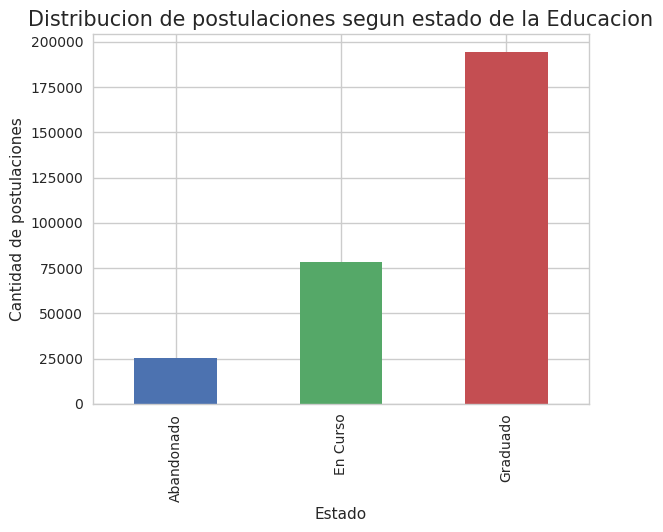

In [130]:
post_educ_estado = postulaciones_educacion['estado'].value_counts().sort_index().plot(kind='bar')
post_educ_estado.set_title('Distribucion de postulaciones segun estado de la Educacion',fontsize=15)
post_educ_estado.set_xlabel('Estado')
post_educ_estado.set_ylabel('Cantidad de postulaciones');

In [131]:
postulaciones_educacion['estado'][postulaciones_educacion['estado'] == 'Abandonado'].value_counts()

Abandonado    25226
Name: estado, dtype: int64

In [132]:
postulaciones_educacion['estado'][postulaciones_educacion['estado'] == 'En Curso'].value_counts()

En Curso    78531
Name: estado, dtype: int64

In [133]:
postulaciones_educacion['estado'][postulaciones_educacion['estado'] == 'Graduado'].value_counts()

Graduado    194474
Name: estado, dtype: int64

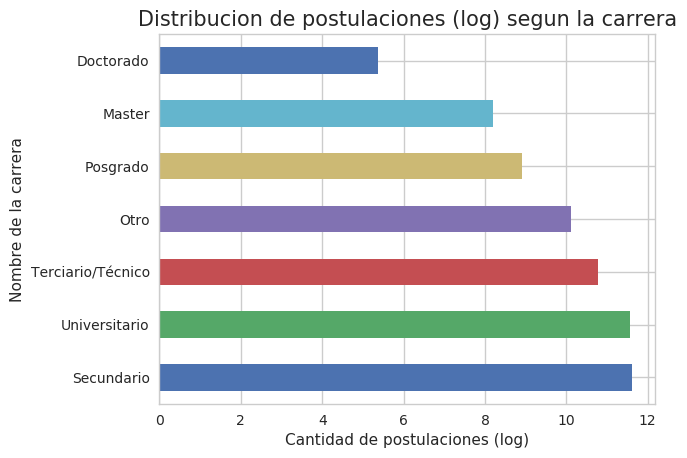

In [414]:
post_educ_carrera = np.log(postulaciones_educacion['nombre'].value_counts() + 1).plot(kind='barh')
post_educ_carrera.set_title('Distribucion de postulaciones (log) segun la carrera',fontsize=15)
post_educ_carrera.set_ylabel('Nombre de la carrera')
post_educ_carrera.set_xlabel('Cantidad de postulaciones (log)');

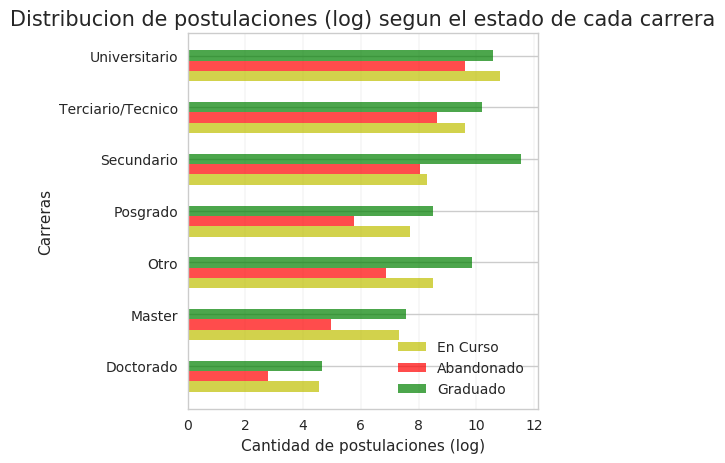

In [413]:
estado_y_carreras = postulaciones_educacion[['nombre','estado']]
benchs_number = 7
benchs_names = ['Doctorado','Master','Otro','Posgrado','Secundario', 'Terciario/Tecnico','Universitario']

arch_en_curso = estado_y_carreras[estado_y_carreras['estado'] == 'En Curso']
arch_graduado = estado_y_carreras[estado_y_carreras['estado'] == 'Graduado']
arch_abandonado = estado_y_carreras[estado_y_carreras['estado'] == 'Abandonado']

#Uso una escala logaritmica asi se pueden ver mejor los datos en el grafico
en_curso = np.log(arch_en_curso['nombre'].value_counts() +1).sort_index()
abandonado = np.log(arch_abandonado['nombre'].value_counts() +1).sort_index()
graduado = np.log(arch_graduado['nombre'].value_counts() +1).sort_index()

index = np.arange(len(benchs_names))

bar_width = 0.2
opacity = 0.5

plt.barh(index, en_curso, bar_width, alpha=0.7,color='y',label='En Curso',)
plt.barh(index+bar_width, abandonado, bar_width, alpha=0.7,color='r',label='Abandonado')
plt.barh(index+2*bar_width, graduado, bar_width, alpha=0.7,color='g',label='Graduado')

plt.grid(True, axis='x', linewidth=0.2)
plt.title('Distribucion de postulaciones (log) segun el estado de cada carrera',fontsize = 15)
plt.ylabel('Carreras')
plt.xlabel('Cantidad de postulaciones (log)')
plt.yticks(index + 2*bar_width, benchs_names)
plt.legend()

plt.tight_layout()
plt.show()

In [378]:

postulaciones_genero_edad['edad'] = pd.to_datetime(postulaciones_genero_edad['fechanacimiento'],errors='coerce').dt.year
postulaciones_genero_edad['edad'] = 2018 - postulaciones_genero_edad['edad']
postulaciones_genero_edad.sort_values(by='edad', ascending=True)

,idpostulante,fechanacimiento,sexo,edad
6869,a5qWAm,2006-01-01,MASC,12.0
189303,2zPBvao,2000-01-28,MASC,18.0
195635,8MP35lM,2000-02-28,MASC,18.0
174014,zvaWZjK,2000-01-09,FEM,18.0
161634,zvaQWRb,2000-01-29,FEM,18.0
174005,Yj5YM6D,2000-01-24,MASC,18.0
173992,1QPGOQB,2000-05-29,FEM,18.0
199869,zvab34m,2000-02-16,FEM,18.0
173968,6rPGoDR,2000-01-24,MASC,18.0
173958,1QPG0dz,2000-09-06,FEM,18.0


In [356]:
postulaciones_genero_edad.fillna(0)
edad_postulantes = pd.DataFrame(columns=['edad'])
edad_postulantes['edad'] = postulaciones_genero_edad['edad'][(postulaciones_genero_edad['edad'] > 17) & (postulaciones_genero_edad['edad'] < 71)]
edad_postulantes['edad'] = edad_postulantes['edad'].astype(int)
edad_postulantes.sort_values(by='edad', ascending = True)

,edad
194894,18
166889,18
189512,18
196317,18
159177,18
175490,18
189076,18
194856,18
185247,18
179457,18


In [429]:
postulaciones_genero_edad = postulaciones_genero_edad.fillna(0)
postulaciones_genero_edad['edad'] = postulaciones_genero_edad['edad'].astype(int)
postulaciones_genero_edad = postulaciones_genero_edad[(postulaciones_genero_edad['edad'] <71) & (postulaciones_genero_edad['edad'] > 17)]
postulaciones_genero_edad.head()

,idpostulante,fechanacimiento,sexo,edad
0,NM5M,1970-12-03,FEM,48
1,5awk,1962-12-04,FEM,56
2,ZaO5,1978-08-10,FEM,40
3,NdJl,1969-05-09,MASC,49
4,eo2p,1981-02-16,MASC,37


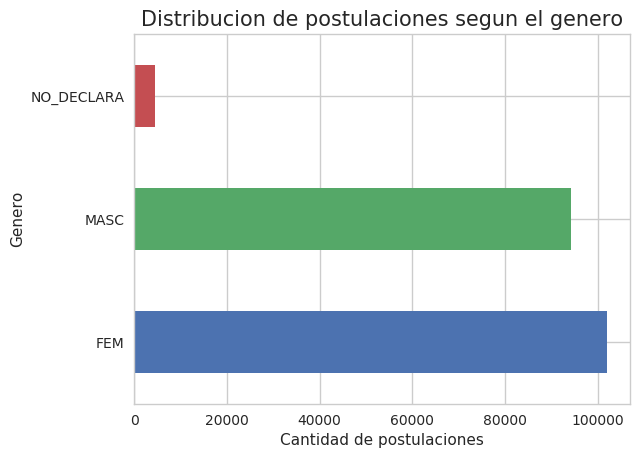

In [427]:
post_genero = postulaciones_genero_edad['sexo'].value_counts().plot(kind='barh')
post_genero.set_title('Distribucion de postulaciones segun el genero',fontsize=15)
post_genero.set_ylabel('Genero')
post_genero.set_xlabel('Cantidad de postulaciones');

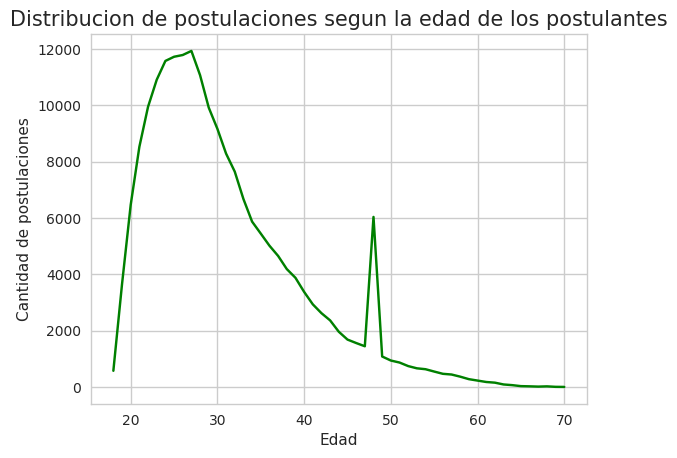

In [426]:
post_edad = edad_postulantes['edad'].value_counts().sort_index().plot(kind='line',color='green')
post_edad.set_title('Distribucion de postulaciones segun la edad de los postulantes',fontsize=15)
post_edad.set_xlabel('Edad')
post_edad.set_ylabel('Cantidad de postulaciones');



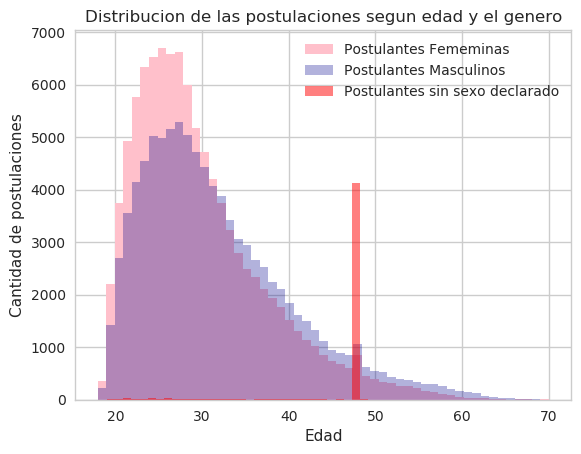

In [446]:
femenino = pd.DataFrame(columns = ['genero','edad'])
masculino = pd.DataFrame(columns = ['genero','edad'])
no_declara = pd.DataFrame(columns = ['genero','edad'])

femenino = postulaciones_genero_edad[postulaciones_genero_edad['sexo'] == 'FEM']
masculino = postulaciones_genero_edad[postulaciones_genero_edad['sexo'] == 'MASC']
no_declara = postulaciones_genero_edad[postulaciones_genero_edad['sexo'] == 'NO_DECLARA']

#plt.hist(femenino['edad'], bins=53, color='pink',label= 'Postulantes Fememinas')
#plt.hist(masculino['edad'], bins=53, color='darkblue',alpha=0.3, label='Postulantes Masculinos')
#plt.hist(no_declara['edad'], bins=53, color='red',alpha=0.5, label='Postulantes sin sexo declarado')

plt.xlabel('Edad')
plt.ylabel('Cantidad de postulaciones')
plt.title('Distribucion de las postulaciones segun edad y el genero')
plt.legend()
plt.show()

In [447]:
#Cantidad de postulaciones de personas que no declaran su sexo segun su edad.
no_declara['edad'].value_counts().head()

48    4127
21      32
24      29
26      28
29      23
Name: edad, dtype: int64

In [433]:
avisos_detalle.head()

,idaviso,idpais,titulo,nombre_zona,tipo_de_trabajo,nivel_laboral,nombre_area
0,8725750,1,VENDEDOR/A PROVINCIA DE SANTA FE,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Comercial
1,17903700,1,Enfermeras,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Salud
2,1000150677,1,Chofer de taxi,Capital Federal,Full-time,Senior / Semi-Senior,Transporte
3,1000610287,1,CHOFER DE CAMIONETA BAHIA BLANCA - PUNTA ALTA,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Transporte
4,1000872556,1,Operarios de Planta - Rubro Electrodomésticos,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Producción


Senior / Semi-Senior                    9407
Junior                                  2216
Otro                                     921
Jefe / Supervisor / Responsable          809
Gerencia / Alta Gerencia / Dirección     181
Name: nivel_laboral, dtype: int64

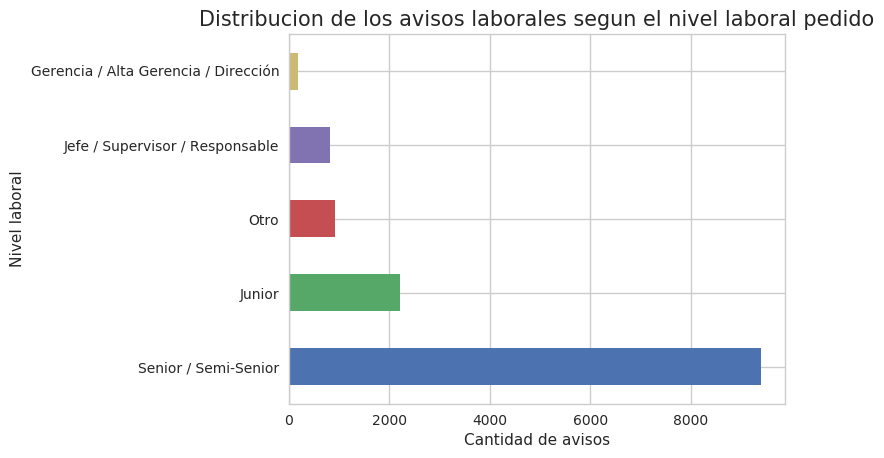

In [244]:
avisos_nivel_laboral = avisos_detalle['nivel_laboral'].value_counts().plot(kind='barh')
avisos_nivel_laboral.set_title('Distribucion de los avisos laborales segun el nivel laboral pedido',fontsize=15)
avisos_nivel_laboral.set_xlabel('Cantidad de avisos')
avisos_nivel_laboral.set_ylabel('Nivel laboral');

avisos_detalle['nivel_laboral'].value_counts()

Full-time          12339
Part-time            863
Teletrabajo          110
Por Horas             63
Pasantia              63
Temporario            42
Por Contrato          37
Fines de Semana       14
Primer empleo          3
Name: tipo_de_trabajo, dtype: int64

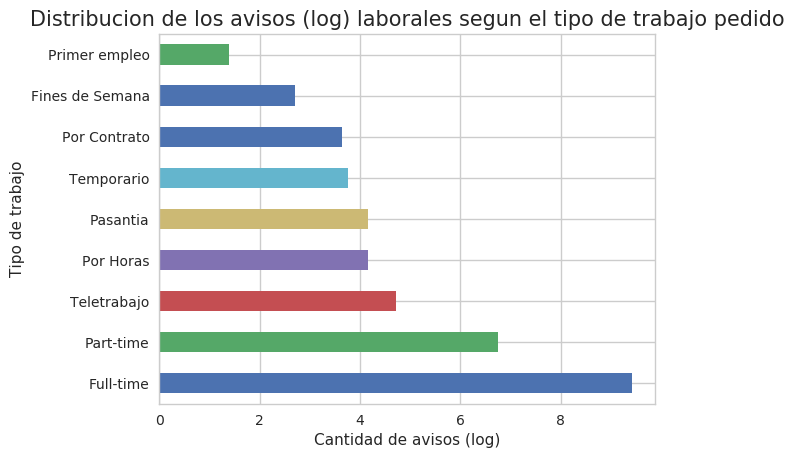

In [412]:
avisos_tipo_de_trabajo = np.log(avisos_detalle['tipo_de_trabajo'].value_counts()+1).plot(kind='barh')
avisos_tipo_de_trabajo.set_title('Distribucion de los avisos (log) laborales segun el tipo de trabajo pedido',fontsize=15)
avisos_tipo_de_trabajo.set_ylabel('Tipo de trabajo')
avisos_tipo_de_trabajo.set_xlabel('Cantidad de avisos (log)');

avisos_detalle['tipo_de_trabajo'].value_counts()

Gran Buenos Aires              12654
Capital Federal                  876
GBA Oeste                          2
Buenos Aires (fuera de GBA)        2
Name: nombre_zona, dtype: int64

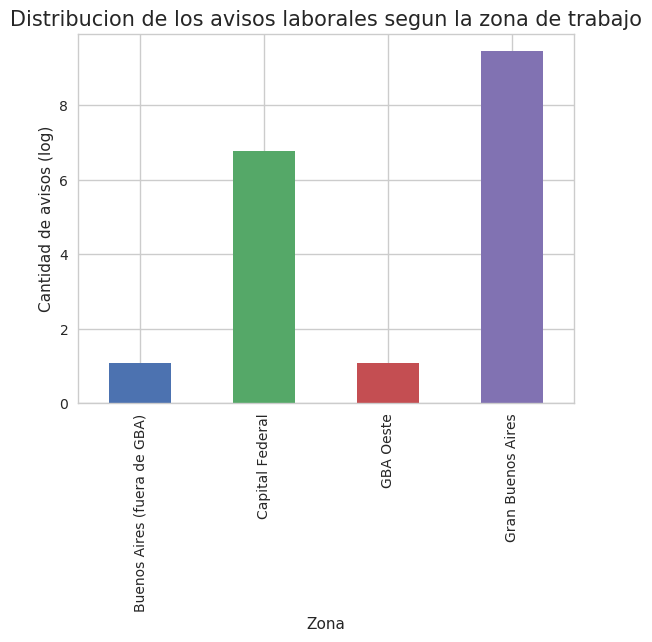

In [415]:
avisos_zona = np.log(avisos_detalle['nombre_zona'].value_counts() + 1).sort_index().plot(kind='bar')
avisos_zona.set_title('Distribucion de los avisos laborales segun la zona de trabajo',fontsize=15)
avisos_zona.set_xlabel('Zona')
avisos_zona.set_ylabel('Cantidad de avisos (log)');

avisos_detalle['nombre_zona'].value_counts()

# Comenzar con el merge de los datos


In [416]:
vistas.head()

,idAviso,timestamp,idpostulante
0,1111780242,2018-02-23T13:38:13.187-0500,YjVJQ6Z
1,1112263876,2018-02-23T13:38:14.296-0500,BmVpYoR
2,1112327963,2018-02-23T13:38:14.329-0500,wVkBzZd
3,1112318643,2018-02-23T13:38:17.921-0500,OqmP9pv
4,1111903673,2018-02-23T13:38:18.973-0500,DrpbXDP


In [417]:
avisos_online.head()

,idaviso
0,1112355872
1,1112335374
2,1112374842
3,1111984070
4,1111822480


In [418]:
#RENOMBRO LA COLUMNA 'idAviso' DEL DF VISTAS PARA QUE COINCIDA CON EL DE AVISOS_ONLINE
vistas = vistas.rename(columns={'idAviso':'idaviso'})

In [419]:
#HAGO UN MERGE PARA VER SOLO LOS AVISOS ONLINE QUE HALLAN SIDO VISTOS
avisos_online_vistos = pd.merge(vistas, avisos_online, on='idaviso', how='inner')

In [420]:
#MERGE PARA VER LOS AVISOS ONLINE Y OFFLINE VISTOS POR POSTULANTES
avisos_vistos_por_postulantes = pd.merge(vistas, postulaciones_genero_edad, on='idpostulante', how='inner')

In [421]:
#Hacer un merge con con los datos de el estado de las carreras y los sexos
postulantes_educacion_genero = pd.merge(postulaciones_genero_edad, postulaciones_educacion, on='idpostulante', how='inner')
postulantes_educacion_genero.head()

,idpostulante,fechanacimiento,sexo,edad,nombre,estado
0,NM5M,1970-12-03,FEM,48.0,Secundario,Graduado
1,5awk,1962-12-04,FEM,56.0,Universitario,Graduado
2,5awk,1962-12-04,FEM,56.0,Terciario/Técnico,Graduado
3,ZaO5,1978-08-10,FEM,40.0,Terciario/Técnico,Graduado
4,ZaO5,1978-08-10,FEM,40.0,Universitario,Abandonado
